# Hamiltonian Monte Carlo

HMC examples from the [minimc](https://github.com/ColCarroll/minimc) repository by Colin Carroll.

In [1]:
import autograd.numpy as np
from minimc import neg_log_normal, mixture, hamiltonian_monte_carlo, neg_log_mvnormal
from minimc.minimc_slow import hamiltonian_monte_carlo as hmc_slow
from minimc.autograd_interface import AutogradPotential

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=16)
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif', serif='palatino')

## 1D Gaussian Sampling

### Fast HMC to Generate Coordinates $x$

Sample from a Gaussian distribution with $\mu=0$ and $\sigma=0.1$, starting from $x=0$.

In [2]:
samples_1d = hamiltonian_monte_carlo(2000, AutogradPotential(neg_log_normal(0, 0.1)),
                                     initial_position=0.0)

100%|██████████| 2500/2500 [00:05<00:00, 435.14it/s]


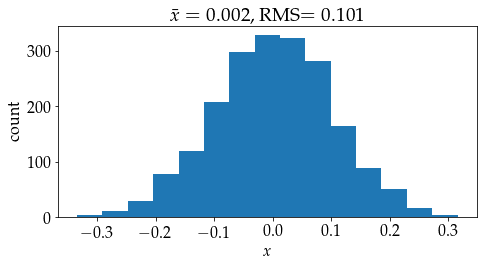

In [3]:
fig, ax = plt.subplots(1,1, figsize=(7,4), tight_layout=True)
ax.hist(samples_1d, bins=15)
ax.set(xlabel='$x$', ylabel='count',
       title='$\\bar{{x}}={:.3f}$, RMS$={:.3f}$'.format(np.average(samples_1d), np.std(samples_1d)));

### Slow HMC to Compute $x$, $p$ Trajectories

Generate 50 samples and their phase space trajectories.

In [4]:
samples, positions, momenta, accepted, p_accepts = hmc_slow(
    50, AutogradPotential(neg_log_normal(0, 0.1)), 0.0, step_size=0.01)

100%|██████████| 50/50 [00:01<00:00, 36.19it/s]


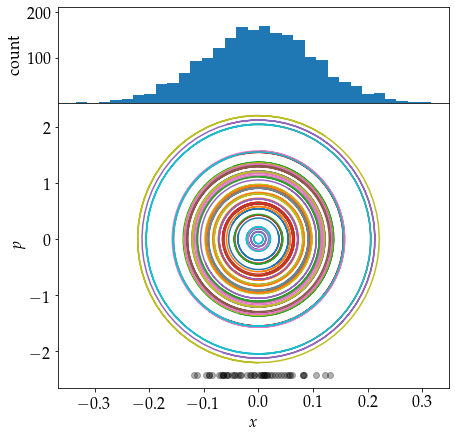

In [8]:
fig, axes = plt.subplots(2,1, figsize=(7,7), sharex=True,
                         gridspec_kw={'wspace':0, 'hspace':0, 'height_ratios':[1,3]})

cmap = mpl.cm.viridis

ax = axes[0]
ax.hist(samples_1d, bins='auto')
ax.set(ylim=(1,210), ylabel='count')

ax = axes[1]
for q, p in zip(positions, momenta):
    ax.plot(q, p)
    
y_min, _ = ax.get_ylim()
ax.plot(samples, y_min + np.zeros_like(samples), 'ko', alpha=0.3)
ax.set(xlabel=r'$x$', ylabel=r'$p$');

## 2D Gaussian

Sample from a multivariate Gaussian of form

$$
p(\boldsymbol{x}|\boldsymbol\mu,\,\boldsymbol\Sigma) = \frac{\exp\left(-\frac 1 2 ({\mathbf x}-{\boldsymbol\mu})^\mathrm{T}{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu})\right)}{\sqrt{(2\pi)^k|\boldsymbol\Sigma|}},
$$

in this case a bivariate (2D) Gaussian function where $\mathbf{x}=(x,y)$.

### Generate 1000 Samples and Plot

In [9]:
mu = np.zeros(2)
cov = np.array([[1.0, 0.8], [0.8, 1.0]])
neg_log_p = AutogradPotential(neg_log_mvnormal(mu, cov))

samples = hamiltonian_monte_carlo(1000, neg_log_p, np.zeros(2))

100%|██████████| 1500/1500 [00:02<00:00, 729.52it/s]


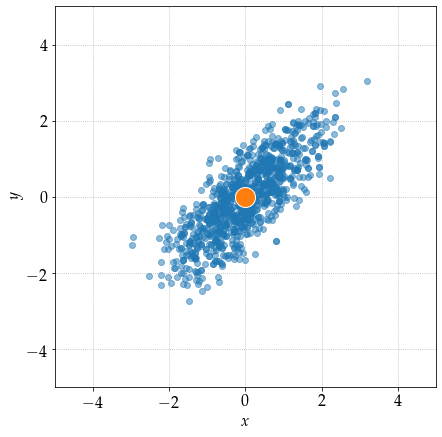

In [10]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.5)
ax.plot(mu[0], mu[1], 'o', color='w', ms=20, mfc='C1')

ax.set(xlim=(-5,5), xlabel='$x$',
       ylim=(-5,5), ylabel='$y$',
       aspect='equal')
ax.grid(ls=':');

### Generate 10 Samples and Plot Trajectories

In [11]:
np.random.seed(19)

samples, positions, momentums, accepted, p_accepts = hmc_slow(
    10, neg_log_p, np.random.randn(2), path_len=4, step_size=0.01,)

100%|██████████| 10/10 [00:02<00:00,  4.47it/s]


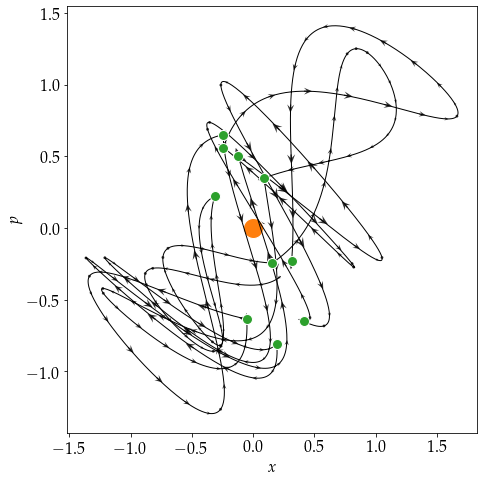

In [12]:
### Plot 4 ###
fig, ax = plt.subplots(1,1, figsize=(7,7), tight_layout=True)

steps = slice(None, None, 20)
ax.plot(mu[0], mu[1], "o", color="w", ms=20, mfc="C1")

for q, p in zip(positions, momentums):
    ax.quiver(
        q[steps, 0],
        q[steps, 1],
        p[steps, 0],
        p[steps, 1],
        headwidth=6,
        scale=80,
        headlength=7,
        alpha=0.8,
    )
    ax.plot(q[:, 0], q[:, 1], 'k-', lw=1)

ax.plot(samples[:, 0], samples[:, 1], 'o', color='w', mfc='C2', ms=10)

ax.set(xlabel='$x$', ylabel='$p$');

## 1D Gaussian Mixture Model

Sample a PDF that is a mixture of several 1D Gaussian functions.

### Generate a Sample of 2000

In [13]:
neg_log_probs = [
    neg_log_normal(-1.0, 0.3),
    neg_log_normal(0.0, 0.2),
    neg_log_normal(1.0, 0.3),
]
probs = np.array([0.1, 0.5, 0.4])
neg_log_p = AutogradPotential(mixture(neg_log_probs, probs))
samples_mixture = hamiltonian_monte_carlo(2000, neg_log_p, 0.0)

100%|██████████| 2500/2500 [00:09<00:00, 260.66it/s]


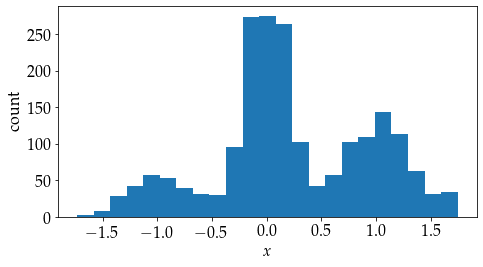

In [14]:
fig, ax = plt.subplots(1,1, figsize=(7,4), tight_layout=True)
ax.hist(samples_mixture, bins='auto')
ax.set(xlabel='$x$', ylabel='count');

### Generate 100 Trajectories

Generate and plot full phase space trajectories!

In [15]:
np.random.seed(2)
samples, positions, momenta, accepted, p_accepts = hmc_slow(
    100, neg_log_p, 0.0, step_size=0.01)

100%|██████████| 100/100 [00:09<00:00, 10.19it/s]


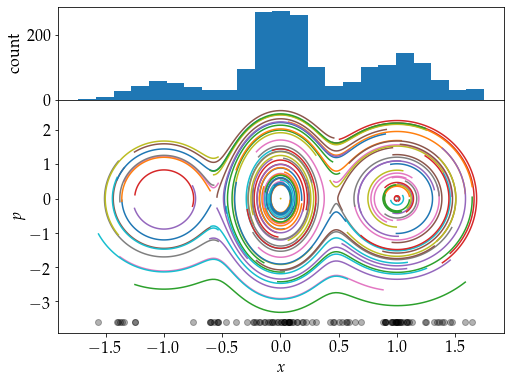

In [17]:
fig, axes = plt.subplots(2,1, figsize=(8,6), sharex=True,
                         gridspec_kw={'wspace':0, 'hspace':0, 'height_ratios':[1,2.5]})

ax = axes[0]
ax.hist(samples_mixture, bins='auto')
ax.set(ylabel='count')

ax = axes[1]
for q, p in zip(positions, momenta):
    ax.plot(q, p)

y_min, _ = ax.get_ylim()
ax.plot(samples, y_min + np.zeros_like(samples), 'ko', alpha=0.3)
ax.set(xlabel='$x$', ylabel='$p$');

## Bivariate Gaussian Mixture Model

Sample from a PDF that is a combination of several 2D Gaussian functions.

### Generate 2000 Samples

In [18]:
mu1 = np.ones(2)
cov1 = 0.5 * np.array([[1.0, 0.7], [0.7, 1.0]])
mu2 = -np.ones(2)
cov2 = 0.2 * np.array([[1.0, -0.6], [-0.6, 1.0]])

mu3 = np.array([-1.0, 2.0])
cov3 = 0.3 * np.eye(2)

neg_log_p = AutogradPotential(
    mixture(
        [
            neg_log_mvnormal(mu1, cov1),
            neg_log_mvnormal(mu2, cov2),
            neg_log_mvnormal(mu3, cov3),
        ],
        [0.3, 0.3, 0.4],
    )
)

samples = hamiltonian_monte_carlo(2000, neg_log_p, np.zeros(2))

100%|██████████| 2500/2500 [00:10<00:00, 237.20it/s]


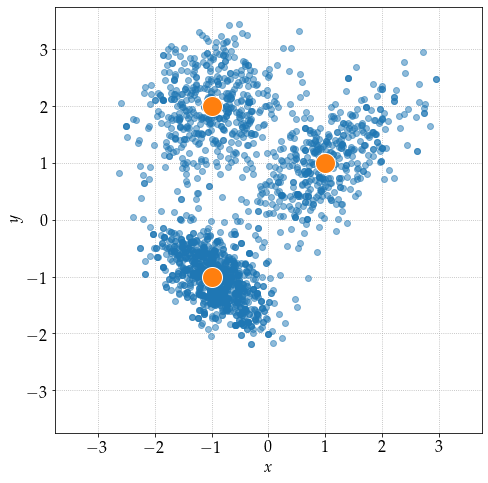

In [19]:
fig, ax = plt.subplots(1,1, figsize=(7,7), tight_layout=True)

means = np.array([mu1, mu2, mu3])
ax.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.5)
ax.plot(means[:, 0], means[:, 1], 'o', color='w', ms=20, mfc='C1')
ax.set(xlim=(-3.75,3.75), xlabel='$x$',
       ylim=(-3.75,3.75), ylabel='$y$',
       aspect='equal')
ax.grid(ls=':')

### Generate 20 Trajectories in Phase Space

In [20]:
np.random.seed(2)

samples, positions, momentums, accepted, p_accepts = hmc_slow(
    20, neg_log_p, np.zeros(2), path_len=3, step_size=0.01)

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


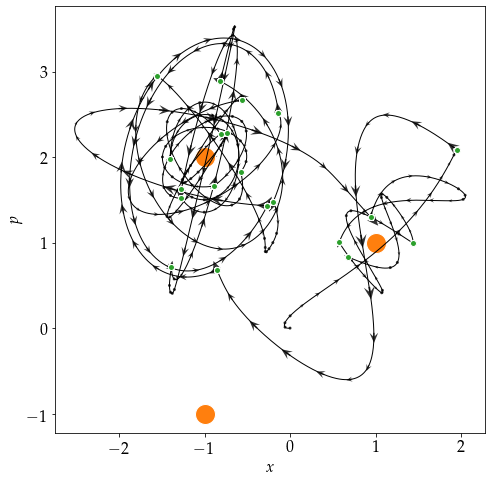

In [21]:
fig, ax = plt.subplots(1,1, figsize=(10,7), tight_layout=True)

steps = slice(None, None, 20)

ax.plot(means[:, 0], means[:, 1], "o", color="w", ms=20, mfc="C1")
for q, p in zip(positions, momentums):
    ax.quiver(
        q[steps, 0],
        q[steps, 1],
        p[steps, 0],
        p[steps, 1],
        headwidth=6,
        scale=100,
        headlength=7,
        alpha=0.8,
    )
    ax.plot(q[:, 0], q[:, 1], "k-", lw=1)
    ax.plot(samples[:, 0], samples[:, 1], "o", color="w", mfc="C2")
    
ax.set(xlabel='$x$', ylabel='$p$', aspect='equal');